In [2]:
from IPython.core.display import HTML, Markdown, display

import numpy.random as npr
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
from cycler import cycler
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.formula.api as smf
from celluloid import Camera
import ipywidgets as widgets
from matplotlib.patches import Polygon
from matplotlib.gridspec import GridSpec

class Caption:
    def __init__(self, fig_no, text, c_type='f'):
        self.fig_no = fig_no
        self.text = text
        if c_type=='t':
            self.c_type = 'Table'
        else:
            self.c_type = 'Figure'
    
    def _repr_html_(self):
        return f"<div class=\"alert alert-info\" role=\"alert\"><b>{ self.c_type } { self.fig_no }</b>. { self.text }</div>"

# Comparing two means

This chapter is adapted from Danielle Navarro's excellent [Learning Statistics with R](https://learningstatisticswithr.com) book.  The main text has mainly be left intact with a few modifications, also the code adapted to use python and jupyter.

## The paired-samples $t$-test

Regardless of whether we're talking about the Student test or the Welch test, an independent samples $t$-test is intended to be used in a situation where you have two samples that are, well, independent of one another. This situation arises naturally when participants are assigned randomly to one of two experimental conditions, but it provides a very poor approximation to other sorts of research designs. In particular, a repeated measures design -- in which each participant is measured (with respect to the same outcome variable) in both experimental conditions -- is not suited for analysis using independent samples $t$-tests. For example, we might be interested in whether listening to music reduces people's working memory capacity. To that end, we could measure each person's working memory capacity in two conditions: with music, and without music. In an experimental design such as this one, each participant appears in *both* groups. This requires us to approach the problem in a different way; by using the **_paired samples $t$-test_**.

At this point we have Drs Harpo, Chico and Zeppo. No prizes for guessing who Dr Groucho is.

### The data

The data set that we'll use this time comes from Dr Chico's class. In her class, students take two major tests, one early in the semester and one later in the semester. To hear her tell it, she runs a very hard class, one that most students find very challenging; but she argues that by setting hard assessments, students are encouraged to work harder. Her theory is that the first test is a bit of a "wake up call" for students: when they realise how hard her class really is, they'll work harder for the second test and get a better mark. Is she right? To test this, let's have a look at the `chico.csv` file: 

In [3]:
chico_df=pd.read_csv('http://gureckislab.org/courses/fall19/labincp/data/chico.csv',index_col=0)
chico_df.head()

,id,grade_test1,grade_test2
1,student1,42.9,44.6
2,student2,51.8,54.0
3,student3,71.7,72.3
4,student4,51.6,53.4
5,student5,63.5,63.8


The pandas data frame `chico` contains three variables: an `id` variable that identifies each student in the class, the `grade_test1` variable that records the student grade for the first test, and the `grade_test2` variable that has the grades for the second test. Above are the first five students.

At a glance, it does seem like the class is a hard one (most grades are between 50\% and 60\%), but it does look like there's an improvement from the first test to the second one. If we take a quick look at the descriptive statistics

In [4]:
chico_df.describe()

,grade_test1,grade_test2
count,20.000000,20.000000
mean,56.980000,58.385000
std,6.616137,6.405612
min,42.900000,44.600000
25%,51.750000,53.100000
50%,57.700000,59.700000
75%,62.050000,63.050000
max,71.700000,72.300000


we see that this impression seems to be supported. Across all 20 students the mean grade for the first test is 57\%, but this rises to 58\% for the second test. Although, given that the standard deviations are 6.6\% and 6.4\% respectively, it's starting to feel like maybe the improvement is just illusory; maybe just random variation. This impression is reinforced when you see the means and confidence intervals plotted in Figure 12. If we were to rely on this plot alone, we'd come to the same conclusion that we got from looking at the descriptive statistics that the `describe()` function produced. Looking at how wide those confidence intervals are, we'd be tempted to think that the apparent improvement in student performance is pure chance.

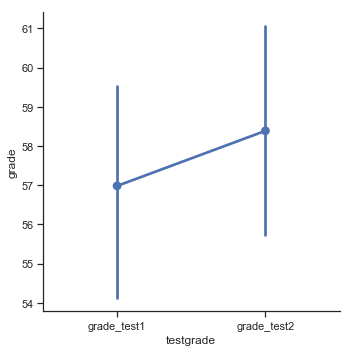

In [5]:
chico_tidy_df = chico_df.melt(id_vars='id', var_name="testgrade", value_name='grade')
sns.catplot(x='testgrade',y='grade',kind='point',data=chico_tidy_df)

plt.show()
display(Caption(12.0, "Mean grade for test 1 and test 2, with associated 95% confidence intervals."))

Nevertheless, this impression is wrong. To see why, take a look at the scatterplot of the grades for test 1 against the grades for test 2 shown in Figure 12. 

In [6]:
chico_df.head()

,id,grade_test1,grade_test2
1,student1,42.9,44.6
2,student2,51.8,54.0
3,student3,71.7,72.3
4,student4,51.6,53.4
5,student5,63.5,63.8


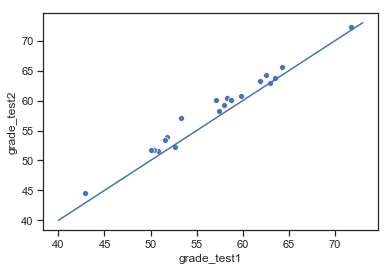

In [7]:
sns.scatterplot(x=chico_df['grade_test1'],y=chico_df['grade_test2'])
x=np.linspace(40,73,100)
plt.plot(x,x)
plt.show()
display(Caption(13.0, "Scatterplot showing the individual grades for test 1 and test 2"))

In this plot, each dot corresponds to the two grades for a given student: if their grade for test 1 ($x$ co-ordinate) equals their grade for test 2 ($y$ co-ordinate), then the dot falls on the line. Points falling above the line are the students that performed better on the second test. Critically, almost all of the data points fall above the diagonal line: almost all of the students *do* seem to have improved their grade, if only by a small amount. This suggests that we should be looking at the *improvement* made by each student from one test to the next, and treating that as our raw data. To do this, we'll need to create a new variable for the `improvement` that each student makes, and add it to the `chico` data frame. The easiest way to do this is as follows: 

In [45]:
chico_df['improvement']=chico_df['grade_test2']-chico_df['grade_test1']

Notice that I assigned the output to a variable called `chico$improvement`. That has the effect of creating a new variable called `improvement` inside the `chico` data frame. So now when I look at the `chico` data frame, I get an output that looks like this:

In [46]:
chico_df.head()

,id,grade_test1,grade_test2,improvement
1,student1,42.9,44.6,1.7
2,student2,51.8,54.0,2.2
3,student3,71.7,72.3,0.6
4,student4,51.6,53.4,1.8
5,student5,63.5,63.8,0.3


Now that we've created and stored this `improvement` variable, we can draw a histogram showing the distribution of these improvement scores (using the `hist()` function), shown in Figure 14. 

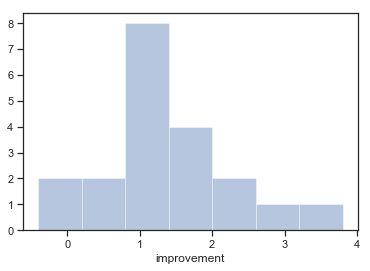

In [129]:
sns.distplot(chico_df.improvement,kde=False)
plt.show()
display(Caption(14.0, "Histogram of improvement variable."))

When we look at histogram, it's very clear that there *is* a real improvement here. The vast majority of the students scored higher on the test 2 than on test 1, reflected in the fact that almost the entire histogram is above zero. In fact, if we use `ciMean()` to compute a confidence interval for the population mean of this new variable, 

In [67]:
def mean_confidence_interval(data, confidence=0.95):
    a = data
    n = len(a)
    m, se = np.mean(a), stats.sem(a)
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return pd.DataFrame({"mean":[m], "lower 95CI": [m-h], "upper 95CI":[m+h]})

chico_df.improvement.aggregate(mean_confidence_interval).round(2)

,mean,lower 95CI,upper 95CI
0,1.4,0.95,1.86


we see that it is 95\% certain that the true (population-wide) average improvement would lie between 0.95\% and 1.86\%. So you can see, qualitatively, what's going on: there is a real "within student" improvement (everyone improves by about 1\%), but it is very small when set against the quite large "between student" differences (student grades vary by about 20\% or so). 

### What is the paired samples $t$-test?

In light of the previous exploration, let's think about how to construct an appropriate $t$ test. One possibility would be to try to run an independent samples $t$-test using `grade_test1` and `grade_test2` as the variables of interest. However, this is clearly the wrong thing to do: the independent samples $t$-test assumes that there is no particular relationship between the two samples. Yet clearly that's not true in this case, because of the repeated measures structure to the data. To use the language that I introduced in the last section, if we were to try to do an independent samples $t$-test, we would be conflating the **_within subject_** differences (which is what we're interested in testing) with the **_between subject_** variability (which we are not). 

The solution to the problem is obvious, I hope, since we already did all the hard work in the previous section. Instead of running an independent samples $t$-test on `grade_test1` and `grade_test2`, we run a *one-sample* $t$-test on the within-subject difference variable, `improvement`. To formalise this slightly, if $X_{i1}$ is the score that the $i$-th participant obtained on the first variable, and $X_{i2}$ is the score that the same person obtained on the second one, then the difference score is:
$$
D_{i} = X_{i1} - X_{i2} 
$$
Notice that the difference scores is *variable 1 minus variable 2* and not the other way around, so if we want improvement to correspond to a positive valued difference, we actually want "test 2" to be our "variable 1". Equally, we would say that $\mu_D = \mu_1 - \mu_2$ is the population mean for this difference variable. So, to convert this to a hypothesis test, our null hypothesis is that this mean difference is zero; the alternative hypothesis is that it is not:
$$
\begin{array}{ll}
H_0: & \mu_D = 0  \\
H_1: & \mu_D \neq 0
\end{array}
$$
(this is assuming we're talking about a two-sided test here). This is more or less identical to the way we described the hypotheses for the one-sample $t$-test: the only difference is that the specific value that the null hypothesis predicts is 0. And so our $t$-statistic is defined in more or less the same way too. If we let $\bar{D}$ denote the mean of the difference scores, then 
$$
t = \frac{\bar{D}}{\mbox{SE}({\bar{D}})}
$$
which is 
$$
t = \frac{\bar{D}}{\hat\sigma_D / \sqrt{N}}
$$
where $\hat\sigma_D$ is the standard deviation of the difference scores. Since this is just an ordinary, one-sample $t$-test, with nothing special about it, the degrees of freedom are still $N-1$. And that's it: the paired samples $t$-test really isn't a new test at all: it's a one-sample $t$-test, but applied to the difference between two variables. It's actually very simple; the only reason it merits a discussion as long as the one we've just gone through is that you need to be able to recognise *when* a paired samples test is appropriate, and to understand *why* it's better than an independent samples $t$ test.

## Doing the test in Python


How do you do a paired samples $t$-test in python. One possibility is to follow the process I outlined above: create a "difference" variable and then run a one sample $t$-test on that. Since we've already created a variable called `chico$improvement`, let's do that:

In [69]:
pg.ttest(x=chico_df.improvement, y=0).round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,6.48,19,two-sided,0.0,"[0.95, 1.86]",1.45,5991.577,1.0


The output here is (obviously) formatted exactly the same was as it was the last time we used the `ttest()` function, and it confirms our intuition. There's an average improvement of 1.4\% from test 1 to test 2, and this is significantly different from 0 ($t(19)=6.48, p<.001$). 

However, suppose you're lazy and you don't want to go to all the effort of creating a new variable. Or perhaps you just want to keep the difference between one-sample and paired-samples tests clear in your head. If so, you can still use the `ttest()` function. Let's assume that your data organised like they are in the `chico` data frame, where there are two separate variables, one for each measurement. You can still provide each column as group 1 and group 2 as before but just indicate they are paried with the argument `paired=True`:

In [72]:
group1 = chico_df.grade_test1
group2 = chico_df.grade_test2
pg.ttest(x=group1, y=group2, paired=True).round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-6.48,19,two-sided,0.0,"[-1.86, -0.95]",0.22,5991.577,0.15


The numbers are identical to those that come from the one sample test on the improvment column, which of course they have to be given that the paired samples $t$-test is just a one sample test under the hood.

## One sided tests

When introducing the theory of null hypothesis tests, I mentioned that there are some situations when it's appropriate to specify a *one-sided* test (see above). So far, all of the $t$-tests have been two-sided tests. For instance, when we specified a one sample $t$-test for the grades in Dr Zeppo's class, the null hypothesis was that the true mean was 67.5\%. The alternative hypothesis was that the true mean was greater than *or* less than 67.5\%. Suppose we were only interested in finding out if the true mean is greater than 67.5\%, and have no interest whatsoever in testing to find out if the true mean is lower than 67.5\%. If so, our null hypothesis would be that the true mean is 67.5\% or less, and the alternative hypothesis would be that the true mean is greater than 67.5\%. The pingouin `ttest()` function lets you do this, by specifying the `tail` argument. If you set `tail="greater"`, it means that you're testing to see if the true mean is larger than `mu`. If you set `tail="less"`, then you're testing to see if the true mean is smaller than `mu`. Here's how it would work for Dr Zeppo's class:

For this reason as long as you specify the `tail` correct you don't need to worry about it!

What about the paired samples $t$-test? Suppose we wanted to test the hypothesis that grades go *up* from test 1 to test 2 in Dr Zeppo's class, and are not prepared to consider the idea that the grades go down. Again, we can use the `tail` argument to specify the one-sided test, and it works the same way it does for the independent samples $t$-test.  If your data are in wide form, as they are in the `chico` data frame, you'd use this command:

In [79]:
group1 = chico_df.grade_test1
group2 = chico_df.grade_test2
pg.ttest(x=group1, y=group2, paired=True, tail='one-sided').round(2)

,T,dof,tail,p-val,CI95%,cohen-d,BF10,power
T-test,-6.48,19,less,0.0,"[-inf, -1.03]",0.22,1.198e+04,0.24


Yet again, the output changes in a predictable way. The hypotheses have changed, the $p$-value has changed, and the confidence interval is now one-sided. 